In [27]:
# coding: utf-8
import pandas as pd
from pathlib import Path
import json
root = Path('.')
root = root.absolute()
test_cases_root = root / "testcases"
results_root = root / "fmcad_results_2023-05-16_23-03-02/"

In [28]:
print("root: ", root)
print("test_cases_root: ", test_cases_root)
print("results_root: ", results_root)
# cwd
print("cwd: ", Path.cwd())

root:  /home/eytan/Work/TheSy/experiments/cvc4_newth_alltogether
test_cases_root:  /home/eytan/Work/TheSy/experiments/cvc4_newth_alltogether/testcases
results_root:  /home/eytan/Work/TheSy/experiments/cvc4_newth_alltogether/fmcad_results_2023-05-16_23-03-02
cwd:  /home/eytan/Work/TheSy/experiments/cvc4_newth_alltogether


In [29]:
test_cases = [y for x in test_cases_root.iterdir() for y in x.iterdir() if y.suffix == ".th"]
rel_cases = [x.relative_to(test_cases_root) for x in test_cases]
configs = [x.name for x in results_root.iterdir() if x.is_dir()]
jsons = {n: pd.read_csv(results_root /  n / "stats.csv") for n in configs}
# Rename columns such that Unnamed: 0 is the test suite nameL
jsons = {n: j.rename(columns={"Unnamed: 0": "test_suite"}) for n, j in jsons.items()}
# Assert test suite column of first configurations contains at least one case of clam
assert any(jsons[configs[0]]["test_suite"].str.contains("clam"))
for n, j in jsons.items():
    j["relative_path"] = j.apply(lambda x: (Path(x["test_suite"]) / x['file_name'].replace('stats.json', 'th')), axis=1)

In [30]:
from numpy import NaN


colored_stats = {}
# Calculate relative_path for each test case
for n, j in jsons.items():
    # From .at
    j["num_terms_added"] = 0
    def get_at(row):
        at_path = results_root / n / row['relative_path'].with_suffix(".at")
        if at_path.exists():
            with at_path.open() as f:
                return len(f.readlines())
        else:
            return None
    j["num_terms_added"] = j.apply(get_at, axis=1)
    # From stats.json
    j["total_search_time"] = NaN
    j['total_apply_time'] = NaN
    j['total_rebuild_time'] = NaN
    def get_stats(row):
        stats_path = results_root / n / row['relative_path'].with_suffix(".stats.json")
        if stats_path.exists():
            with stats_path.open() as f:
                return json.load(f)
        else:
            return None
    stats = j.apply(get_stats, axis=1)
    j['total_search_time'] = stats.apply(lambda s: s['total_search_time'])
    j['total_apply_time'] = stats.apply(lambda s: s['total_apply_time'])
    j['total_rebuild_time'] = stats.apply(lambda s: s['total_rebuild_time'])

    # From colored_stats.json
    j["total_enodes"] = NaN
    j["num_splits"] = 0
    j["should_delete"] = NaN
    j["deleted_colored_enodes"] = NaN
    j["colored_unions_count"] = NaN
    j['total_colors_size'] = NaN
    j['black_size'] = NaN
    j['vacuos_colors'] = NaN
    j['split_sizes'] = NaN
    j['graph_memory'] = NaN
    j['eclasses_count'] = NaN
    j['id_count'] = NaN
    j['colored_unions_count'] = NaN
    j['deleted_colored_enodes'] = NaN
    j['colored_equivalences_size'] = NaN
    j['black_colored_classes_size'] = NaN
    j['parent_color_tracking_size'] = NaN
    

    # Find all existing colored_stats.json files by iterating over j['relative_path']
    def get_max(row):
        x = row['relative_path']
        # Find all colored_stats.json files
        cs_path = results_root / n / x.with_suffix(".colored_stats.json")
        if cs_path.exists():
            with cs_path.open() as f:
                cs = json.load(f)
                colored_stats[(n, x)] = cs
            filtered = [x[1] for x in cs]
            for stats in filtered:
                stats['total_enodes'] = stats['black_size']
                if 'colors_sizes' in stats:
                    stats['total_enodes'] += sum(stats['colors_sizes'].values())
                if 'split_sizes' in stats:
                    stats['total_enodes'] += sum(stats['split_sizes'])
            # take max of total_enodes from filtered and add it to j
            return max(filtered, key=lambda x: x['total_enodes'])
        else:
            return None
        
    def collect_num_splits(stats):
        if 'colors_sizes' in stats:
            return len(stats['colors_sizes'])
        elif 'split_sizes' in stats:
            return len(stats['split_sizes'])
        else:
            return 0
        
    max_stats = j.apply(get_max, axis=1)
    
    # do by arity 
        # by_arity: IndexMap<usize, usize>,
    j['total_enodes'] = max_stats.apply(lambda s: s['total_enodes'])
    j['num_splits'] = max_stats.apply(collect_num_splits)
    j['should_delete'] = max_stats.apply(lambda s: sum(s['should_delete'].values()) if 'should_delete' in s else 0)
    j['deleted_colored_enodes'] = max_stats.apply(lambda s: s['deleted_colored_enodes'])
    j['colored_unions_count'] = max_stats.apply(lambda s: s['colored_unions_count'])
    j['total_colors_size'] = max_stats.apply(lambda s: sum([v for k, v in s['colors_sizes'].items()]) if 'colors_sizes'in s else 0)
    j['black_size'] = max_stats.apply(lambda s: s['black_size'])
    j['vacuos_colors'] = max_stats.apply(lambda s: len(s['vacuos_colors']) if 'vacuos_colors' in s else 0)
    j['split_sizes'] = max_stats.apply(lambda s: sum(s['split_sizes']) if 'split_sizes' in s else 0)
    j['graph_memory'] = max_stats.apply(lambda s: s['graph_memory'])
    j['eclasses_count'] = max_stats.apply(lambda s: s['eclasses_count'])
    j['id_count'] = max_stats.apply(lambda s: s['id_count'])
    j['colored_unions_count'] = max_stats.apply(lambda s: s['colored_unions_count'])
    j['deleted_colored_enodes'] = max_stats.apply(lambda s: s['deleted_colored_enodes'])
    j['colored_equivalences_size'] = max_stats.apply(lambda s: s['colored_equivalences_size'])
    j['black_colored_classes_size'] = max_stats.apply(lambda s: s['black_colored_classes_size'])
    j['parent_color_tracking_size'] = max_stats.apply(lambda s: s['parent_color_tracking_size'])

In [31]:
# Start adding missing files by first adding an error column
for j in jsons.values():
    j["error"] = None

# Now add the missing files. For each missing case find the corresponding error file
for n, j in jsons.items():
    # Find missing cases by relative path to rel_cases
    in_df = j['relative_path'].unique()
    missing_cases = [r for r in rel_cases if r not in in_df]
    for fn in missing_cases:
        errors = (results_root / n / fn.with_suffix('.err')).read_text()
        j.loc[len(j)] = {"relative_path": fn, "error": errors, 'time': 3600}
        

In [32]:
for n, j in jsons.items():
    fixed_config = n.replace('case_split_proof_split_', '')
    split_depth = int(fixed_config[0])
    features = fixed_config[2:]
    j['split_depth'] = split_depth
    j['features'] = features
    # Reindex by relative_path + features + split_depth
    j.set_index(['relative_path', 'features', 'split_depth'], drop=False, inplace=True)

In [33]:
j = list(jsons.values())[0]
print(j.columns)

Index(['test_suite', 'Unnamed: 1', 'time', 'stop_reasons', 'success',
       'lemma_count', 'proofs_later_filtered', 'case_split_root_count',
       'case_split_had_vacuity', 'total_allocated', 'max_allocated',
       'file_name', 'relative_path', 'num_terms_added', 'total_search_time',
       'total_apply_time', 'total_rebuild_time', 'total_enodes', 'num_splits',
       'should_delete', 'deleted_colored_enodes', 'colored_unions_count',
       'total_colors_size', 'black_size', 'vacuos_colors', 'split_sizes',
       'graph_memory', 'eclasses_count', 'id_count',
       'colored_equivalences_size', 'black_colored_classes_size',
       'parent_color_tracking_size', 'error', 'split_depth', 'features'],
      dtype='object')


In [34]:
# Write our all new csv files as updated_stats.csv
for n, j in jsons.items():
    j.to_csv(results_root / (n[23:] + "_updated_stats.csv"))

master_df = pd.concat(jsons.values())
master_df.to_csv(results_root / "master_updated_stats.csv")

In [ ]:
# Now collect unique configs and print
unique_configs = master_df['features'].drop_duplicates()
print(unique_configs)

relative_path         features                       split_depth
isaplanner/goal13.th  split_no_cmemo_stats           4                       split_no_cmemo_stats
isaplanner/goal50.th  split_clone_keep_splits_stats  3              split_clone_keep_splits_stats
                      split_colored_stats            3                        split_colored_stats
                      split_clone_stats              1                          split_clone_stats
isaplanner/goal13.th  split_no_cremove_stats         4                     split_no_cremove_stats
Name: features, dtype: object


In [167]:
# For all split depth find all cases where split_num in split_clone_keep_splits_stats is different from split_num in split_colored_stats
keeps = []
colored = []
no_cmemo = []
no_cremove = []
for depth in range(1, 5):
    keeps.append(master_df[(master_df['split_depth'] == depth) & (master_df['features'] == 'split_clone_keep_splits_stats')])
    colored.append(master_df[(master_df['split_depth'] == depth) & (master_df['features'] == 'split_colored_stats')])
    no_cmemo.append(master_df[(master_df['split_depth'] == depth) & (master_df['features'] == 'split_no_cmemo_stats')])
    no_cremove.append(master_df[(master_df['split_depth'] == depth) & (master_df['features'] == 'split_no_cremove_stats')])
    # remap index to only include relative_path
    keeps[-1].set_index('relative_path', inplace=True)
    colored[-1].set_index('relative_path', inplace=True)
    no_cmemo[-1].set_index('relative_path', inplace=True)
    no_cremove[-1].set_index('relative_path', inplace=True)

In [71]:
for k, c in zip(keeps, colored):
    # Compare the num_splits when error is null
    k = k[k['error'].isnull()]
    c = c[c['error'].isnull()]
    intersection = k.index.intersection(c.index)
    print("Size of k: ", len(k))
    print("Size of c: ", len(c))
    print("Size of intersection: ", len(intersection))
    print(len(k.loc[intersection][k.loc[intersection]['num_splits'] != c.loc[intersection]['num_splits']]))
    print(len(k.loc[intersection][k.loc[intersection]['num_splits'] < c.loc[intersection]['num_splits']]))
    print(len(k.loc[intersection][k.loc[intersection]['num_splits'] > c.loc[intersection]['num_splits']]))

Size of k:  197
Size of c:  197
Size of intersection:  197
3
0
3
Size of k:  194
Size of c:  196
Size of intersection:  193
48
32
16
Size of k:  171
Size of c:  179
Size of intersection:  170
58
30
28
Size of k:  166
Size of c:  146
Size of intersection:  140
32
16
16


# Graphs for memory measurements

Check only cases where no config (per depth) has an error

* Report (total enodes)-black enodes* / # splits    -> the config no_cmemo shouold consider the clone black size as its base black enodes, everything else its own black size
* Report #colored enodes vs #colored unions

Consider seeing how many small colors do we have. That is, is it one color taking all the memory, or is it split evenly?

Size of keep:  125 Size of no_cm:  121 Size of no_cr:  123 Size of color:  34
Size of keep:  122 Size of no_cm:  70 Size of no_cr:  123 Size of color:  34
Size of keep:  99 Size of no_cm:  43 Size of no_cr:  106 Size of color:  34
Size of keep:  94 Size of no_cm:  35 Size of no_cr:  74 Size of color:  34
count    124.000000
mean     117.627633
std      204.453385
min        0.000000
25%        5.875000
50%       18.263889
75%       53.312500
max      599.250000
dtype: float64
Size of intersection:  68
Size of intersection:  68
Size of intersection:  68
Size of intersection:  68


/tmp/ipykernel_28333/190347461.py:53: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 10**4 + 100)


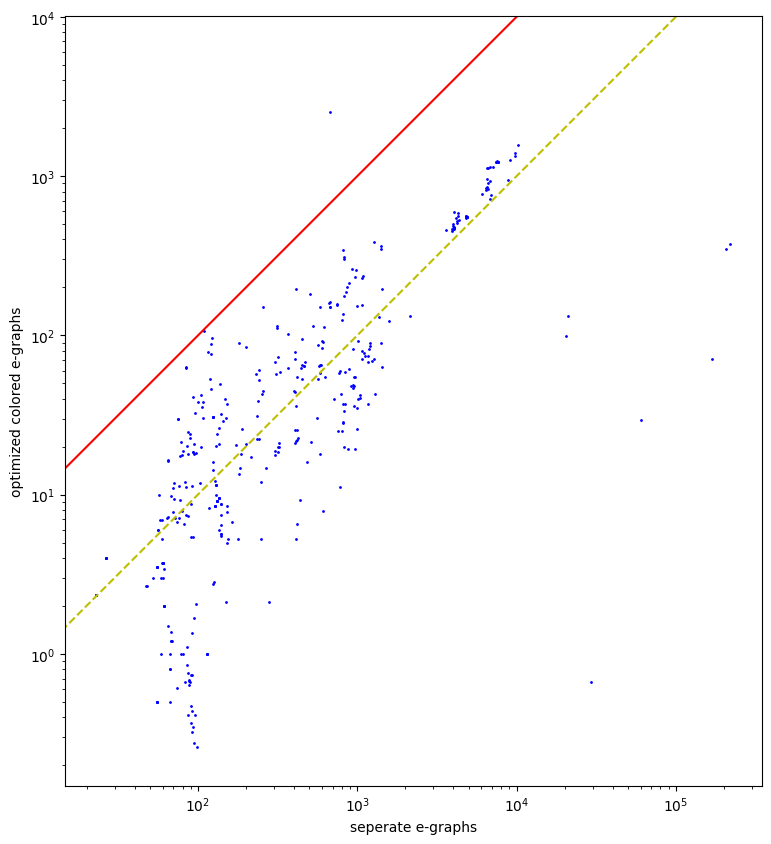

Size of intersection:  68
Size of intersection:  68
Size of intersection:  68
Size of intersection:  68


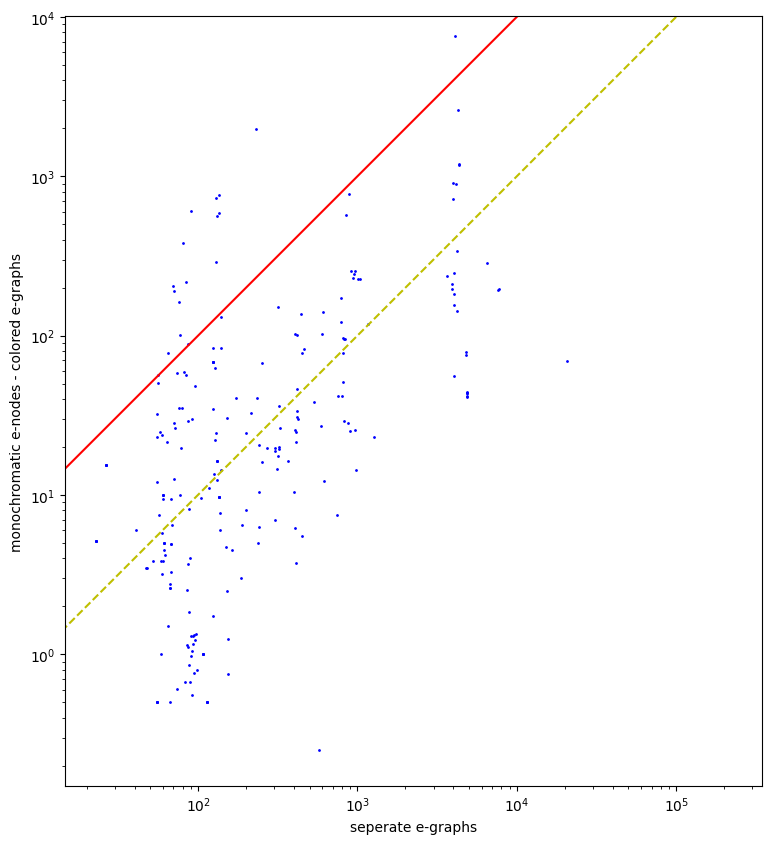

Size of intersection:  68
Size of intersection:  68
Size of intersection:  68
Size of intersection:  68


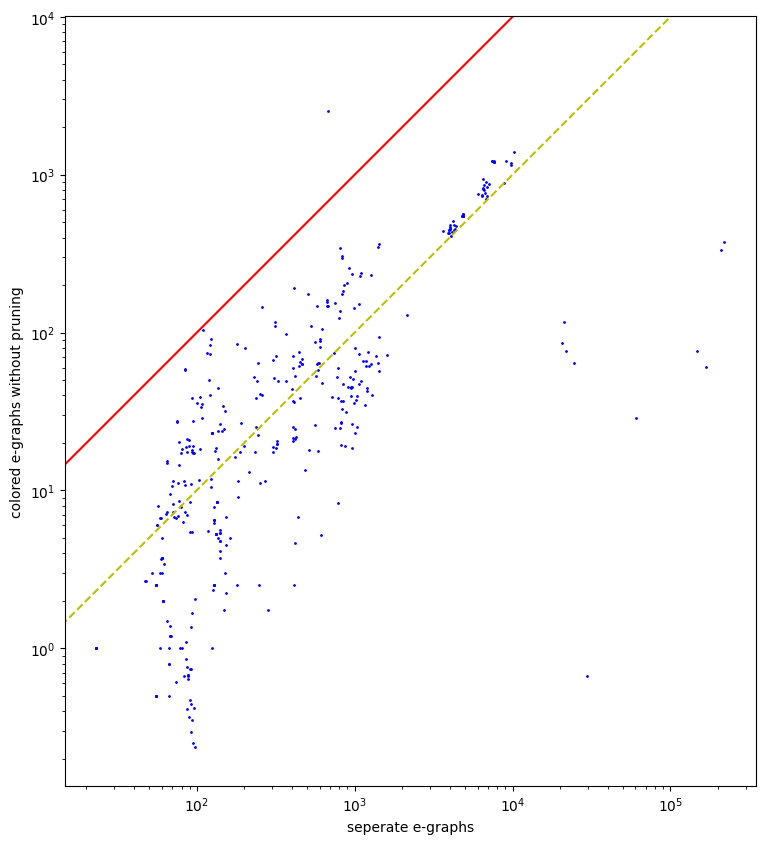

In [184]:
from matplotlib.lines import Line2D
import numpy as np
import matplotlib.pyplot as plt
    

print_keeps = []
print_colored = []
print_no_cmemo = []
print_no_cremove = []
for keep, c, no_cm, no_cr in zip(keeps, colored, no_cmemo, no_cremove):
    keep = keep[keep['error'].isnull() & (keep['num_splits'] > 0)]
    no_cm = no_cm[no_cm['error'].isnull() & (no_cm['num_splits'] > 0)]
    no_cr = no_cr[no_cr['error'].isnull() & (no_cr['num_splits'] > 0)]
    c = c[c['error'].isnull() & (c['num_splits'] > 0)]
    # Print individual sizes in one line
    print("Size of keep: ", len(keep), "Size of no_cm: ", len(no_cm), "Size of no_cr: ", len(no_cr), "Size of color: ", len(color))
    print_keeps.append(keep.apply(lambda s: (s['total_enodes'] - s['black_size']) / s['num_splits'], axis=1))

    no_extra_inter = keep.index.intersection(no_cm.index)
    no_cm_extra = (no_cm.loc[no_extra_inter]['total_enodes'] - keep.loc[no_extra_inter]['black_size']) / no_cm.loc[no_extra_inter]['num_splits']
    print_no_cmemo.append(no_cm_extra)
    no_cr_inter = keep.index.intersection(no_cr.index)
    no_cr = no_cr.loc[no_cr_inter].apply(lambda s: (s['total_enodes'] - s['black_size']) / s['num_splits'], axis=1)
    print_no_cremove.append(no_cr)
    intersection = keep.index.intersection(c.index)
    c = c.loc[intersection].apply(lambda s: (s['total_enodes'] - s['black_size']) / s['num_splits'], axis=1)
    print_colored.append(c)
    
print(print_colored[0].describe())


def plot_scatter(keep_stats, colored_stats, title):
    plt.figure(figsize=(10, 10))

    print_colors = ['red', 'blue', 'green', 'orange']
    max_k = max([k.max() for k in keep_stats])
    max_c = max([c.max() for c in colored_stats])
    for keep, c, print_c in zip(keep_stats, colored_stats, print_colors):
        # Print individual sizes in one line
        keep = keep.loc[c.index]
        print("Size of intersection: ", len(intersection))
        # I should create an xy plot  

        plt.scatter(keep, c, s=1, c='blue')
        # plt.loglog(keep, color, 'b.')
        # plt.scatter(keep, color, s=1)
        plt.xscale('log')
        plt.yscale('log')
        
    plt.gca().set_aspect('equal', adjustable='box')    
    plt.xlabel('seperate e-graphs')
    plt.ylabel(title)
    plt.ylim(0, 10**4 + 100)
    # plt.legend(['split depth 1', '2', '3', '4'])
    line_points = np.linspace(0, max(max_k, max_c), num=100)
    # Draw a yellow dotted line at y = x / 10
    plt.plot(line_points, line_points / 10, 'y--')
    plt.plot(line_points, line_points, 'r-')
    plt.show()

plot_scatter(print_keeps, print_colored, 'optimized colored e-graphs')
plot_scatter(print_keeps, print_no_cmemo, 'monochromatic e-nodes - colored e-graphs')
plot_scatter(print_keeps, print_no_cremove, 'colored e-graphs without pruning')


Fully optimized


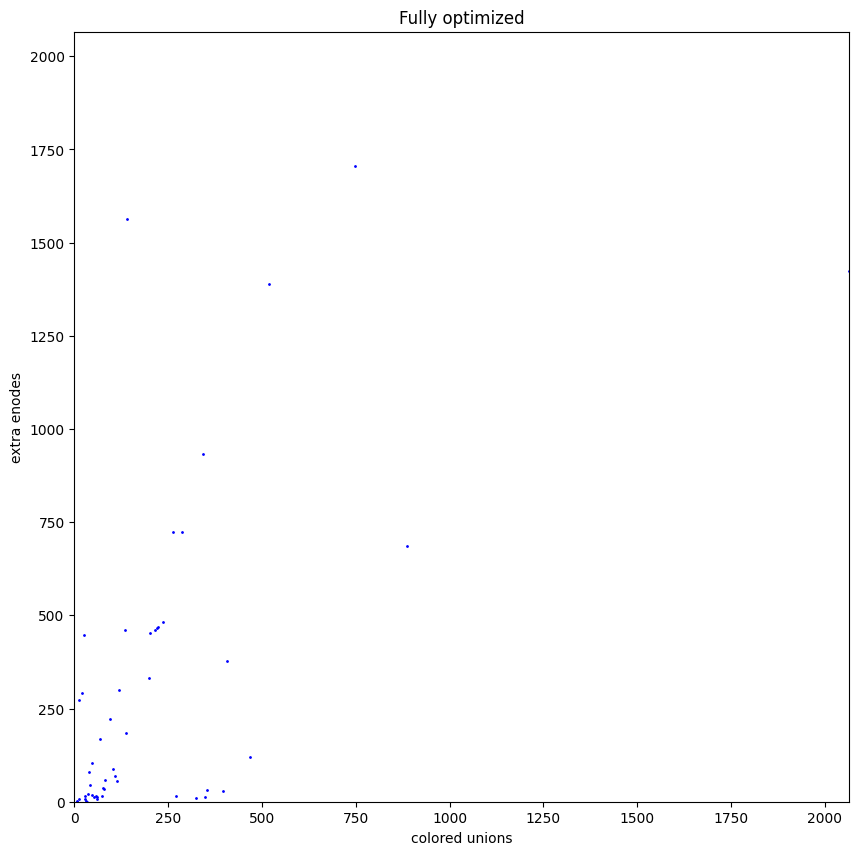

No colored e-nodes


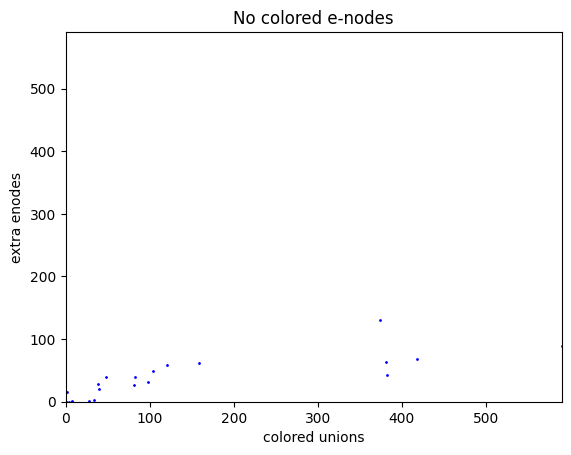

No pruning


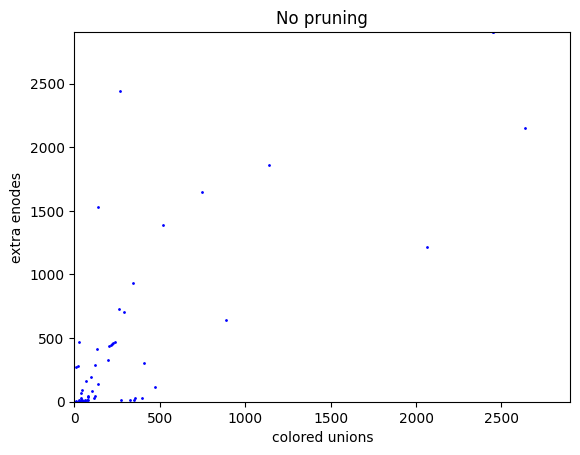

In [151]:
# Now plot number of extra enodes on y axis and number of colored unions on x axis
# colored_cunion = []
# no_cmemo_cunion = []
# no_cremove_cunion = []
for c, no_cm, no_cr, keep in zip(colored, no_cmemo, no_cremove, keeps):
    colored_cunion = []
    no_cmemo_cunion = []
    no_cremove_cunion = []
    c = c.loc[c['error'].isnull() & (c['num_splits'] > 0)]
    no_cm = no_cm.loc[no_cm['error'].isnull() & (no_cm['num_splits'] > 0)]
    # intersect no_cm and keep
    keep = keep.loc[keep['error'].isnull() & (keep['num_splits'] > 0)]
    no_cm = no_cm.loc[no_cm.index.intersection(keep.index)]
    no_cr = no_cr.loc[no_cr['error'].isnull() & (no_cr['num_splits'] > 0)]
    colored_cunion.append((c['colored_unions_count'], c['total_enodes'] - c['black_size'], c['num_splits']))
    no_cmemo_cunion.append((no_cm['colored_unions_count'], no_cm['total_enodes'] - keep.loc[no_cm.index]['black_size'], no_cm['num_splits']))
    no_cremove_cunion.append((no_cr['colored_unions_count'], no_cr['total_enodes'] - no_cr['black_size'], no_cr['num_splits']))


# concat it to a single dataframe
colored_cunion = pd.concat([pd.DataFrame({'colored_unions_count': c, 'extra_enodes': extra, 'num_splits': num_splits}) for c, extra, num_splits in colored_cunion])
no_cmemo_cunion = pd.concat([pd.DataFrame({'colored_unions_count': c, 'extra_enodes': extra, 'num_splits': num_splits}) for c, extra, num_splits in no_cmemo_cunion])
no_cremove_cunion = pd.concat([pd.DataFrame({'colored_unions_count': c, 'extra_enodes': extra, 'num_splits': num_splits}) for c, extra, num_splits in no_cremove_cunion])

# Remove outliers using IQR method but only for selected columns   
def remove_outliers(df, columns):
    for column in columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        df = df.loc[df[column].between(q1 - 1.5 * iqr, q3 + 1.5 * iqr)]
    return df

# Plot a line figure with a line for each split depth
plt.figure(figsize=(10, 10))
for config in [(colored_cunion, "Fully optimized"), (no_cmemo_cunion, "No colored e-nodes"), (no_cremove_cunion, "No pruning")]:
    data, title = config
    # for conf in iters:
    print(title)
    plt.title(title)
    # plt.gca().set_aspect('equal', adjustable='box')    
    plt.xlabel('colored unions')
    plt.ylabel("extra enodes")
    print_colors = ['red', 'blue', 'green', 'orange']
    data = remove_outliers(data, ['colored_unions_count', 'extra_enodes'])
    max_scale = max(data['colored_unions_count'].max(), data['extra_enodes'].max())
    c = data['colored_unions_count']
    extra = data['extra_enodes']
    # Set the x and y axis to be the same scale
    plt.xlim(0, max_scale)
    plt.ylim(0, max_scale)
    plt.scatter(c, extra, s=1, c='blue')
    plt.show()

In [152]:
# show value counts of errors
master_df[(master_df['split_depth'] == depth) & (master_df['features'] == 'split_no_cmemo_stats')]['error'].value_counts()

error
Timeout Exception                                                                                                                                                                                                                                                                                                                                  89
11:06:24 [ERROR] Unrecognized token `=>` found at 3771:3773\nExpected one of "(", "=", "?", r#"#[^#]+#"# or r#"[a-zA-Z+\\-/_*&$%^@0-9]+"#\nthread 'main' panicked at 'Please implement error handling', src/thesy/semantics.rs:123:17\nnote: run with `RUST_BACKTRACE=1` environment variable to display a backtrace\n                18
thread 'main' panicked at 'called `Result::unwrap()` on an `Err` value: UnrecognizedToken { token: (1, Token(13, "=>"), 3), expected: ["\"(\"", "\"=\"", "\"?\"", "r#\"#[^#]+#\"#", "r#\"[a-zA-Z+\\\\-/_*&$%^@0-9]+\"#"] }', src/bin/expl_experiment.rs:127:34\nnote: run with `RUST_BACKTRACE=1` environment variable to display a

In [153]:
master_df[(master_df['split_depth'] == depth) & (master_df['features'] == 'split_colored_stats')]['error'].value_counts()

error
Timeout Exception                                                                                                                                                                                                                                                                                                                                  63
08:34:37 [ERROR] Unrecognized token `=>` found at 3771:3773\nExpected one of "(", "=", "?", r#"#[^#]+#"# or r#"[a-zA-Z+\\-/_*&$%^@0-9]+"#\nthread 'main' panicked at 'Please implement error handling', src/thesy/semantics.rs:123:17\nnote: run with `RUST_BACKTRACE=1` environment variable to display a backtrace\n                18
thread 'main' panicked at 'called `Result::unwrap()` on an `Err` value: UnrecognizedToken { token: (1, Token(13, "=>"), 3), expected: ["\"(\"", "\"=\"", "\"?\"", "r#\"#[^#]+#\"#", "r#\"[a-zA-Z+\\\\-/_*&$%^@0-9]+\"#"] }', src/bin/expl_experiment.rs:127:34\nnote: run with `RUST_BACKTRACE=1` environment variable to display a

In [166]:
# Collect all cases from masterdf where error is null or error = Timeout Exception
runtimes = master_df[master_df['error'].isnull() | (master_df['error'] == 'Timeout Exception')]
runtimes = runtimes.rename(columns={'features': 'features_column', 'split_depth': 'split_depth_column'})
grouped = runtimes.groupby(['features_column', 'split_depth_column', 'test_suite'])

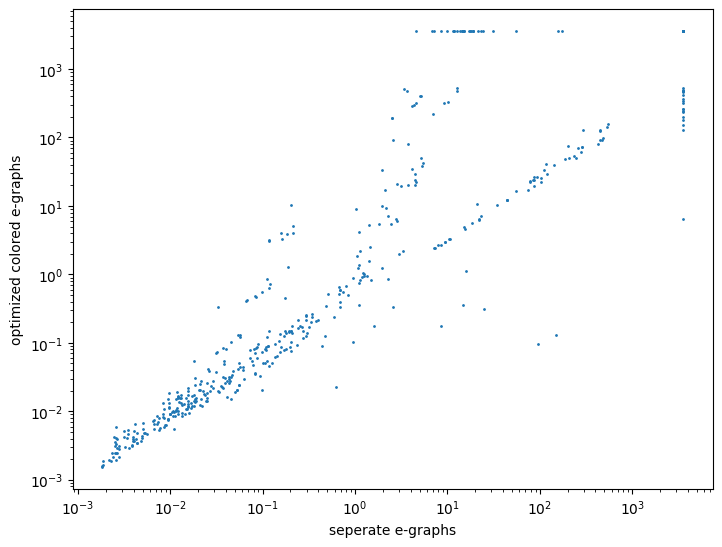

In [191]:
import matplotlib.pyplot as plt

def scatter1(df, config, fig=None, ax=None, values='time', title='colored'):
    pt = pd.pivot_table(df, index=['relative_path', 'split_depth'],
                        columns=['features_column'], values=values)

    if not ax:
        fig = fig or plt.figure()
        ax = fig.add_axes([0,0,1,1])
    
    ax.scatter(pt['split_clone_keep_splits_stats'], pt[config], s=1)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('seperate e-graphs')
    ax.set_ylabel(title)
    return ax


# fig, axes = plt.subplots(1, 4, figsize=(10,2))

temp = master_df.rename(columns={'relative_path': 'relative_path_column', 'features': 'features_column', 'split_depth': 'split_depth_column'})
scatter1(temp.loc[(temp['num_splits'] > 0) | (temp['error'] == 'Timeout Exception')], 'split_colored_stats', values='time', title='optimized colored e-graphs')
plt.show()

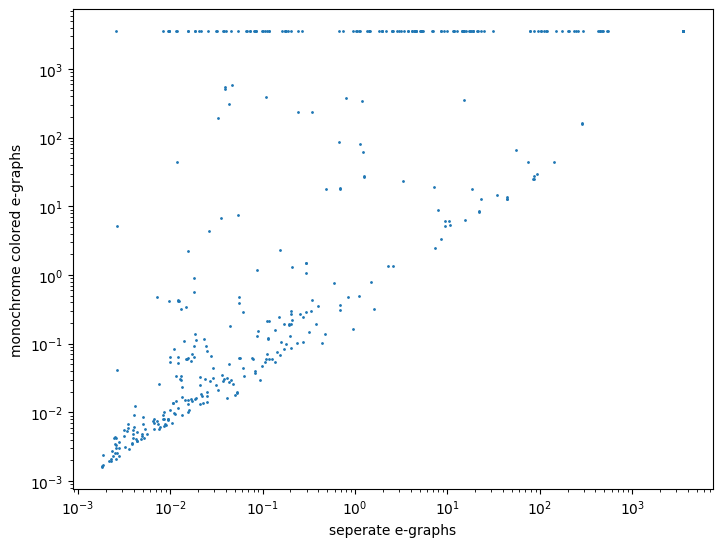

In [194]:
scatter1(temp.loc[(temp['num_splits'] > 0) | (temp['error'] == 'Timeout Exception')], 'split_no_cmemo_stats', values='time', title='monochrome colored e-graphs')
plt.show()

In [192]:
# Now plot number of extra enodes on y axis and number of colored unions on x axis
colored_times = []
no_cmemo_times = []
no_cremove_times = []
keeps_times = []
for c, no_cm, no_cr, keep in zip(colored, no_cmemo, no_cremove, keeps):
    c = c.loc[c['time'].notnull() & (c['num_splits'] > 0)]
    no_cm = no_cm.loc[no_cm['time'].notnull() & (no_cm['num_splits'] > 0)]
    # intersect no_cm and keep
    keep = keep.loc[keep['time'].notnull() & (keep['num_splits'] > 0)]
    no_cr = no_cr.loc[no_cr['time'].notnull() & (no_cr['num_splits'] > 0)]
    colored_times.append(c['time'])
    no_cmemo_times.append(no_cm['time'])
    no_cremove_times.append(no_cr['time'])
    keeps_times.append(keep['time'])

# concat it to a single dataframe
colored_times = pd.concat(colored_times)
no_cmemo_times = pd.concat(no_cmemo_times)
no_cremove_times = pd.concat(no_cremove_times)
keeps_times = pd.concat(keeps_times)

# Remove outliers using IQR method but only for selected columns   
def remove_outliers(df, columns):
    for column in columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        iqr = q3 - q1
        df = df.loc[df[column].between(q1 - 1.5 * iqr, q3 + 1.5 * iqr)]
    return df

x_col = ['num_splits', 'colored_unions_count'][1]
y_col = ['eclasses_count', 'total_enodes'][1]

cfg1, cfg2 = 'split_colored_stats', 'split_clone_keep_splits_stats'

pt = pd.pivot_table(df, index=['relative_path', 'split_depth'],
                        columns=['features'], values=[x_col, y_col])
pt = pt[pt[x_col][cfg1] > 0]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.scatter(pt[x_col][cfg1], pt[y_col][cfg2] / pt[y_col][cfg1], s=1)
ax.set_xscale('log'); 
ax.set_yscale('log')

# # Plot a line figure with a line for each split depth
# plt.figure(figsize=(10, 10))
# for config in [(colored_times, "Fully optimized"), (no_cmemo_times, "No colored e-nodes"), (no_cremove_times, "No pruning")]:
#     data, title = config
#     # for conf in iters:
#     print(title)
#     plt.title(title)
#     # plt.gca().set_aspect('equal', adjustable='box')    
#     plt.xlabel('keeps_times')
#     plt.ylabel(title)
#     print(data)
#     intersection = data.index.intersection(keeps_times.index)
#     k = keeps_times.loc[intersection]
#     c = data.loc[intersection]
#     max_scale = data.max()
#     # Set the x and y axis to be the same scale
#     plt.xlim(0, max_scale)
#     plt.ylim(0, max_scale)
#     plt.scatter(k, c, s=1, c='blue')
#     plt.show()

NameError: name 'df' is not defined